# Logistic Regression with Macro Data

## Imports & Settings

In [ ]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn plots
sns.set_style('whitegrid')

## Data Set

We'll be using a macroeconomic dataset with the following variables:

| Variable   | Description                                  | Transformation     |
|------------|----------------------------------------------|-------------------|
| realgdp    | Real gross domestic product                  | Annual Growth Rate |
| realcons   | Real personal consumption expenditures       | Annual Growth Rate |
| realinv    | Real gross private domestic investment       | Annual Growth Rate |
| realgovt   | Real federal expenditures & gross investment | Annual Growth Rate |
| realdpi    | Real private disposable income               | Annual Growth Rate |
| m1         | M1 nominal money stock                       | Annual Growth Rate |
| tbilrate   | Monthly treasury bill rate                   | Level              |
| unemp      | Seasonally adjusted unemployment rate (%)    | Level              |
| infl       | Inflation rate                               | Level              |
| realint    | Real interest rate                           | Level              |

In [ ]:
# Load the macroeconomic dataset
data = pd.DataFrame(sm.datasets.macrodata.load().data)

# Display information about the dataset
data.info()

# Display the first few rows of the dataset
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB
     year  quarter   realgdp  realcons  realinv  realgovt  realdpi    cpi  \
0  1959.0      1.0  2710.349    1707.4  286.898   470.045   1886.9  28.98   
1  1959.0      2.0  2778.801    1733.7  310.859   481.301   1919.7  29.15  

## Data Prep

To obtain a binary target variable, we compute the 20-quarter rolling average of the annual growth rate of quarterly real GDP. We then assign 1 if current growth exceeds the moving average and 0 otherwise. Finally, we shift the indicator variables to align next quarter's outcome with the current quarter.

In [ ]:
# Calculate the annual growth rate of real GDP
data['growth_rate'] = data.realgdp.pct_change(4)

# Create binary target variable
# 1 if growth rate > 20-quarter moving average, 0 otherwise
# Shift by -1 to align with next quarter's outcome
data['target'] = (data.growth_rate > data.growth_rate.rolling(20).mean()).astype(int).shift(-1)

# Convert quarter to integer type
data.quarter = data.quarter.astype(int)

# Display value counts of the target variable
print(data.target.value_counts())

target
0.0    112
1.0     90
Name: count, dtype: int64


In [ ]:
# Display the last few rows of the dataset
print(data.tail())

       year  quarter    realgdp  realcons   realinv  realgovt  realdpi  \
198  2008.0        3  13324.600    9267.7  1990.693   991.551   9838.3   
199  2008.0        4  13141.920    9195.3  1857.661  1007.273   9920.4   
200  2009.0        1  12925.410    9209.2  1558.494   996.287   9926.4   
201  2009.0        2  12901.504    9189.0  1456.678  1023.528  10077.5   
202  2009.0        3  12990.341    9256.0  1486.398  1044.088  10040.6   

         cpi      m1  tbilrate  unemp      pop  infl  realint  growth_rate  \
198  216.889  1474.7      1.17    6.0  305.270 -3.16     4.33     0.000262   
199  212.174  1576.5      0.12    6.9  305.952 -8.79     8.91    -0.018619   
200  212.671  1592.8      0.22    8.1  306.547  0.94    -0.71    -0.033026   
201  214.469  1653.6      0.18    9.2  307.226  3.37    -3.19    -0.038297   
202  216.385  1673.9      0.12    9.6  308.013  3.56    -3.44    -0.025086   

     target  
198     0.0  
199     0.0  
200     0.0  
201     0.0  
202     NaN  


In [ ]:
# List of columns to calculate percent change
pct_cols = ['realcons', 'realinv', 'realgovt', 'realdpi', 'm1']

# List of columns to drop
drop_cols = ['year', 'realgdp', 'pop', 'cpi', 'growth_rate']

# Calculate percent change for specified columns
data.loc[:, pct_cols] = data.loc[:, pct_cols].pct_change(4)

# Create dummy variables for 'quarter', drop the first to avoid multicollinearity
# Drop specified columns and remove rows with NaN values
data = pd.get_dummies(data.drop(drop_cols, axis=1), columns=['quarter'], drop_first=True).dropna()

# Convert boolean columns to int
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

# Convert all columns to numeric, errors='coerce' will turn non-numeric values to NaN
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')


# Drop any rows with NaN values after conversion
data = data.dropna()

# Display the first few rows of the processed dataset
print(data.head())

   realcons   realinv  realgovt   realdpi        m1  tbilrate  unemp  infl  \
4  0.036957  0.156237 -0.016692  0.036356 -0.000716      3.50    5.2  2.31   
5  0.034147 -0.040877 -0.043426  0.024170 -0.010586      2.68    5.2  0.14   
6  0.019409  0.024718 -0.033758  0.026821  0.002847      2.36    5.6  2.70   
7  0.019673 -0.132257 -0.015738  0.018278  0.007857      2.29    6.3  1.21   
8  0.009715 -0.196903  0.029544  0.014830  0.017908      2.37    6.8 -0.40   

   realint  target  quarter_2  quarter_3  quarter_4  
4     1.19     0.0          0          0          0  
5     2.55     0.0          1          0          0  
6    -0.34     0.0          0          1          0  
7     1.08     0.0          0          0          1  
8     2.77     0.0          0          0          0  


In [ ]:
# Display information about the processed dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 4 to 201
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   realcons   198 non-null    float64
 1   realinv    198 non-null    float64
 2   realgovt   198 non-null    float64
 3   realdpi    198 non-null    float64
 4   m1         198 non-null    float64
 5   tbilrate   198 non-null    float64
 6   unemp      198 non-null    float64
 7   infl       198 non-null    float64
 8   realint    198 non-null    float64
 9   target     198 non-null    float64
 10  quarter_2  198 non-null    int64  
 11  quarter_3  198 non-null    int64  
 12  quarter_4  198 non-null    int64  
dtypes: float64(10), int64(3)
memory usage: 21.7 KB


We use an intercept and convert the quarter values to dummy variables and train the logistic regression model as follows:

This produces the following summary for our model with 198 observations and 13 variables, including intercept:
The summary indicates that the model has been trained using maximum likelihood and provides the maximized value of the log-likelihood function at -67.9.

In [ ]:
# Prepare the data for logistic regression
X = sm.add_constant(data.drop('target', axis=1))  # Add constant term (intercept)
y = data.target

# Check data types
print(X.dtypes)
print(y.dtype)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Display the summary of the model
print(result.summary())

const        float64
realcons     float64
realinv      float64
realgovt     float64
realdpi      float64
m1           float64
tbilrate     float64
unemp        float64
infl         float64
realint      float64
quarter_2      int64
quarter_3      int64
quarter_4      int64
dtype: object
float64
Optimization terminated successfully.
         Current function value: 0.342965
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  198
Model:                          Logit   Df Residuals:                      185
Method:                           MLE   Df Model:                           12
Date:                Fri, 02 Aug 2024   Pseudo R-squ.:                  0.5022
Time:                        16:12:16   Log-Likelihood:                -67.907
converged:                       True   LL-Null:                       -136.42
Covariance Type:            nonrobust   LLR p-valu

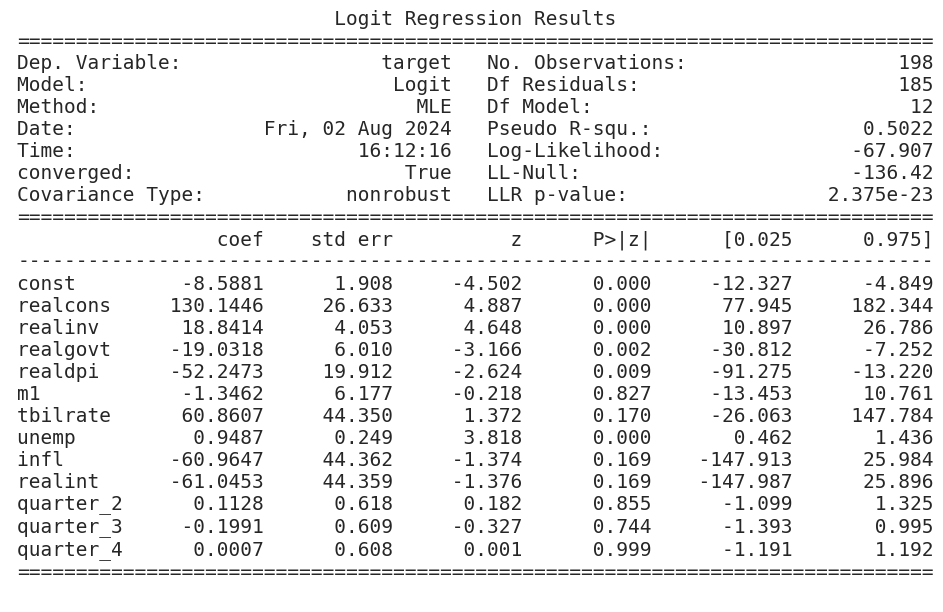

In [ ]:
# The LL-Null value of -136.42 is the result of the maximized log-likelihood function
# when only an intercept is included. It forms the basis for the pseudo-R2 statistic
# and the Log-Likelihood Ratio (LLR) test.

# The pseudo-R2 statistic is a substitute for the familiar R2 available under least squares.
# It is computed based on the ratio of the maximized log-likelihood function for the null
# model m0 and the full model m1.

# Higher values of pseudo-R2 indicate a better fit.

# Create a plot of the model summary
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('logistic_example.png', bbox_inches='tight', dpi=300)